# 03.2_Seleccion_Features_Automatica

---

## Objetivo
Ejecutar y comparar múltiples técnicas de selección automática de características (`ANOVA`, `Información Mutua`, `RFECV`, etc.) sobre los datos de entrenamiento finales.  
El objetivo es identificar el subconjunto de variables más robusto y con mayor poder predictivo para guardar una nueva versión experimental de los splits (entrenamiento, validación y prueba) que contenga únicamente estas características seleccionadas.



## Entradas (Inputs)

- `data/splits/final/X_train.parquet`  
- `data/splits/final/y_train.parquet`  
- `data/splits/final/X_val.parquet`  
- `data/splits/final/y_val.parquet`  
- `data/splits/final/X_test.parquet`  
- `data/splits/final/y_test.parquet`



## Salidas (Outputs)

###  Splits:

- `data/splits/experiments/X_train_14.parquet`  
- `data/splits/experiments/X_val_14.parquet`  
- `data/splits/experiments/X_test_14.parquet`  
- `data/splits/experiments/y_train_14.parquet`  
- `data/splits/experiments/y_val_14.parquet`  
- `data/splits/experiments/y_test_14.parquet`

### Artefactos:

- `artifacts/experiments/03_2_selected_features_rfecv_14.json`  
- `artifacts/experiments/03_2_pipeline_rfecv14_logistic.pkl`  
- `artifacts/experiments/03_2_pipeline_pca_logistic.pkl`

---

## Resumen Ejecutivo
- El notebook automatiza la selección de características para un modelo de **Regresión Logística** sobre los “splits” de entrenamiento, validación y test previamente generados.  
- Se emplean múltiples métodos de feature selection: **SelectKBest (ANOVA)**, **InfoMutua**, **Random Forest (importancia y umbral mediano)**, **RFECV** y un filtrado por frecuencia de selección.  
- Se compara también un enfoque de **reducción de dimensionalidad con PCA** (90 % varianza) frente a las selecciones basadas en árboles y univariadas.  
- Cada subconjunto resultante (p. ej., Top-20 de RFECV, intersección RF∩MI, PCA-64) se evalúa con **LogisticRegression** mediante métricas de precisión, recall, f1-score y accuracy en validación y test.  
- La validación CV sobre distintos tamaños de subset muestra un **plateau de f1_macro (~0.43)** a partir de k = 20 características.  
- La selección univariada (k=20) redujo accuracy (0.46→0.41), mientras que RFECV-Top-20 alcanzó ~0.43 y el pipeline **PCA+Logistic** obtuvo **0.46** en validación y **0.49** en test.  
- Se identifican características recurrentes (e.g., `TRADER_SCORE`, `S_Age`, `B4_log`, variables de series F31, G30) como las más predictivas.  
- Finalmente, los modelos y splits procesados se serializan en **formato Parquet** y **pkl** para facilitar su uso en fases posteriores.

---

## 1. Montaje de Google Drive, configuración de rutas y carga de datos finales
Monta Google Drive, añade la raíz del proyecto al sys.path, carga las rutas desde el módulo config y lee los archivos Parquet de los splits finales. Luego detecta y reordena variables derivadas si existen.

In [ ]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from collections import Counter
import json

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler




# Importar las rutas necesarias desde el archivo de configuración
import config # Import the config module itself
from config import FINAL_SPLITS_DIR, EXP_SPLITS_DIR, EXP_ARTIFACTS_DIR

print("Drive montado y configuración de rutas cargada correctamente.")

# Carga de splits FINALES y variables derivadas

print(f"Cargando datos FINALES desde: {config.FINAL_SPLITS_DIR}")

try:
    # Cargar splits usando la ruta FINAL del archivo config
    X_train = pd.read_parquet(config.FINAL_SPLITS_DIR / 'X_train.parquet')
    y_train = pd.read_parquet(config.FINAL_SPLITS_DIR / 'y_train.parquet').squeeze()

    X_val   = pd.read_parquet(config.FINAL_SPLITS_DIR / 'X_val.parquet')
    y_val   = pd.read_parquet(config.FINAL_SPLITS_DIR / 'y_val.parquet').squeeze()

    X_test  = pd.read_parquet(config.FINAL_SPLITS_DIR / 'X_test.parquet')
    y_test  = pd.read_parquet(config.FINAL_SPLITS_DIR / 'y_test.parquet').squeeze()

    print("Datos cargados correctamente desde formato Parquet.")

    print("\n Shapes tras cargar splits:")
    print(f"   • X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"   • X_val:   {X_val.shape},   y_val:   {y_val.shape}")
    print(f"   • X_test:  {X_test.shape},  y_test:  {y_test.shape}")

    # Variables derivadas esperadas
    derived_vars = [v for v in ['FL_SCORE','PORTFOLIO_DIVERSITY','TRADER_SCORE'] if v in X_train.columns]

    if derived_vars:
        print("\nVariables derivadas encontradas:", derived_vars)
        # Reordenar columnas para poner las derivadas al principio
        X_train = X_train[derived_vars + [c for c in X_train.columns if c not in derived_vars]]
        X_val   = X_val[derived_vars + [c for c in X_val.columns if c not in derived_vars]]
        X_test  = X_test[derived_vars + [c for c in X_test.columns if c not in derived_vars]]
        print(" Reordenadas variables derivadas en los DataFrames")
    else:
        print("\n No se encontraron variables derivadas en X_train.")

except Exception as e:
    print(f"\nOcurrió un error inesperado al cargar los datos: {e}")

Mounted at /content/drive
Módulo de configuración cargado y estructura de carpetas asegurada.
Drive montado y configuración de rutas cargada correctamente.
Cargando datos FINALES desde: /content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/data/splits/final
Datos cargados correctamente desde formato Parquet.

 Shapes tras cargar splits:
   • X_train: (1976, 92), y_train: (1976,)
   • X_val:   (424, 92),   y_val:   (424,)
   • X_test:  (424, 92),  y_test:  (424,)

Variables derivadas encontradas: ['FL_SCORE', 'PORTFOLIO_DIVERSITY', 'TRADER_SCORE']
 Reordenadas variables derivadas en los DataFrames


## 2. Creación y aplicación del escalador a los datos
Instancia un StandardScaler, lo ajusta únicamente con los datos de entrenamiento y transforma los conjuntos de entrenamiento, validación y prueba; finalmente convierte los arrays escalados de vuelta a DataFrames.

In [2]:
# Crear el objeto escalador
scaler = StandardScaler()

# Ajustar el escalador SOLO con los datos de entrenamiento y transformarlos.
X_train_scaled_np = scaler.fit_transform(X_train)

# Aplicar la MISMA transformación (sin volver a ajustar) a los conjuntos de validación y prueba.
X_val_scaled_np = scaler.transform(X_val)
X_test_scaled_np = scaler.transform(X_test)

# Convertir los arrays de NumPy de vuelta a DataFrames de Pandas.
X_train_trans = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)
X_val_trans = pd.DataFrame(X_val_scaled_np, columns=X_val.columns)
X_test_trans = pd.DataFrame(X_test_scaled_np, columns=X_test.columns)

print(" Datos transformados y escalados correctamente.")
print(f"   • Variable 'X_train_trans' creada con shape: {X_train_trans.shape}")
print(f"   • Variable 'X_val_trans' creada con shape: {X_val_trans.shape}")

 Datos transformados y escalados correctamente.
   • Variable 'X_train_trans' creada con shape: (1976, 92)
   • Variable 'X_val_trans' creada con shape: (424, 92)


## 3. Selección de características univariada con ANOVA y evaluación básica
Aplica SelectKBest con función ANOVA (f_classif) para quedarse con las 20 mejores variables, entrena un LogisticRegression con y sin selección, y muestra los informes de clasificación en validación.

In [3]:
# Selección univariada ANOVA
k = 20
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train_trans, y_train)

selected_f = X_train_trans.columns[selector.get_support()].tolist()
print(" Top-k ANOVA (f_classif):", selected_f)

# Entrenar Logistic con y sin selección
# Sin selección
log_basic = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_basic.fit(X_train_trans, y_train)
pred_val_basic = log_basic.predict(X_val_trans)

# Con selección
X_train_sel = selector.transform(X_train_trans)
X_val_sel   = selector.transform(X_val_trans)
log_sel = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_sel.fit(X_train_sel, y_train)
pred_val_sel = log_sel.predict(X_val_sel)

print(" Métricas - Logistic sin selección (validación):")
print(classification_report(y_val, pred_val_basic))

print(" Métricas - Logistic con SelectKBest (validación):")
print(classification_report(y_val, pred_val_sel))

 Top-k ANOVA (f_classif): ['TRADER_SCORE', 'B35', 'B26', 'C22_4', 'F30_3', 'F30_6', 'F30_7', 'F30_8', 'F30_9', 'F30_11', 'F31_2', 'F31_4', 'F31_5', 'F31_6', 'F31_8', 'G1', 'G2', 'G30_3', 'G30_4', 'S_Age']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 Métricas - Logistic sin selección (validación):
              precision    recall  f1-score   support

         1.0       0.28      0.47      0.35        34
         2.0       0.39      0.41      0.40       116
         3.0       0.69      0.46      0.55       233
         4.0       0.28      0.61      0.39        41

    accuracy                           0.46       424
   macro avg       0.41      0.49      0.42       424
weighted avg       0.54      0.46      0.48       424

 Métricas - Logistic con SelectKBest (validación):
              precision    recall  f1-score   support

         1.0       0.34      0.50      0.40        34
         2.0       0.38      0.41      0.40       116
         3.0       0.73      0.35      0.47       233
         4.0       0.21      0.68      0.32        41

    accuracy                           0.41       424
   macro avg       0.41      0.49      0.40       424
weighted avg       0.55      0.41      0.43       424



## 4. Comparación de selección ANOVA vs. InfoMutua
Vuelve a calcular la selección ANOVA, añade SelectKBest con InfoMutua, e identifica solapamientos y diferencias entre ambas listas de features.

In [4]:
# ANOVA (ya calculado como selected_f), repetimos para asegurar
selector_f = SelectKBest(score_func=f_classif, k=k)
selector_f.fit(X_train_trans, y_train)
selected_f = X_train_trans.columns[selector_f.get_support()].tolist()

# Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
selector_mi.fit(X_train_trans, y_train)
selected_mi = X_train_trans.columns[selector_mi.get_support()].tolist()

solapamiento = set(selected_f).intersection(selected_mi)
solo_anova    = set(selected_f) - solapamiento
solo_mi       = set(selected_mi) - solapamiento

print(" Top-k con ANOVA (f_classif):", selected_f)
print(" Top-k con InfoMutua:", selected_mi)
print(f" Solapamiento ({len(solapamiento)}):", solapamiento)
print(f" Solo en ANOVA ({len(solo_anova)}):", solo_anova)
print(f" Solo en InfoMutua ({len(solo_mi)}):", solo_mi)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 Top-k con ANOVA (f_classif): ['TRADER_SCORE', 'B35', 'B26', 'C22_4', 'F30_3', 'F30_6', 'F30_7', 'F30_8', 'F30_9', 'F30_11', 'F31_2', 'F31_4', 'F31_5', 'F31_6', 'F31_8', 'G1', 'G2', 'G30_3', 'G30_4', 'S_Age']
 Top-k con InfoMutua: ['B3', 'B35', 'C22_3', 'D3', 'D21', 'D30', 'F30_3', 'F30_4', 'F30_5', 'F30_8', 'F30_9', 'F31_2', 'F31_4', 'F31_5', 'F31_11', 'G1', 'G2', 'G30_3', 'G30_4', 'S_Age']
 Solapamiento (12): {'F31_5', 'B35', 'F31_2', 'F31_4', 'G30_3', 'G1', 'G2', 'G30_4', 'F30_9', 'F30_8', 'S_Age', 'F30_3'}
 Solo en ANOVA (8): {'F30_7', 'C22_4', 'B26', 'F31_8', 'F31_6', 'TRADER_SCORE', 'F30_11', 'F30_6'}
 Solo en InfoMutua (8): {'F30_4', 'D30', 'B3', 'F30_5', 'F31_11', 'D3', 'D21', 'C22_3'}


## 5. Selección de características basada en Random Forest
Entrena un RandomForestClassifier y emplea SelectFromModel con umbral en la mediana de importancias para extraer las variables más relevantes.

In [5]:
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf_base.fit(X_train_trans, y_train)

selector_sf = SelectFromModel(estimator=rf_base, threshold='median', prefit=True)
sf_features = X_train_trans.columns[selector_sf.get_support()].tolist()

print(f" Número de features seleccionadas por RF (umbral=mediana): {len(sf_features)}")
print(" Features seleccionadas por RF:", sf_features)

 Número de features seleccionadas por RF (umbral=mediana): 46
 Features seleccionadas por RF: ['FL_SCORE', 'PORTFOLIO_DIVERSITY', 'TRADER_SCORE', 'B30', 'B3', 'B4', 'B11', 'B35', 'B24', 'B26', 'C22_1', 'C22_3', 'C22_4', 'C24', 'C25', 'D1_1', 'D1_2', 'D2', 'D3', 'D21', 'D30', 'D31', 'E1_1', 'E5', 'E6', 'F30_1', 'F30_2', 'F30_4', 'F30_7', 'F30_12', 'F31_5', 'F31_6', 'G1', 'G2', 'G30_1', 'G30_2', 'G30_3', 'G30_4', 'G30_6', 'G31', 'G11', 'G12', 'G13', 'S_Age', 'S_Income', 'B4_log']


## 6. Selección recursiva de características con RFECV y visualización
Configura y ajusta RFECV empleando un LogisticRegression y validación cruzada estratificada, obtiene el número óptimo de features, lista seleccionada y dibuja F1_macro vs. número de features.

 Número óptimo de features según RFECV: 17
 Features seleccionadas por RFECV: ['TRADER_SCORE', 'A1', 'B2_2', 'B11', 'B26', 'C24', 'D21', 'D30', 'F30_4', 'F31_2', 'F31_4', 'F31_10', 'G2', 'G30_2', 'H31', 'S_Age', 'B4_log']


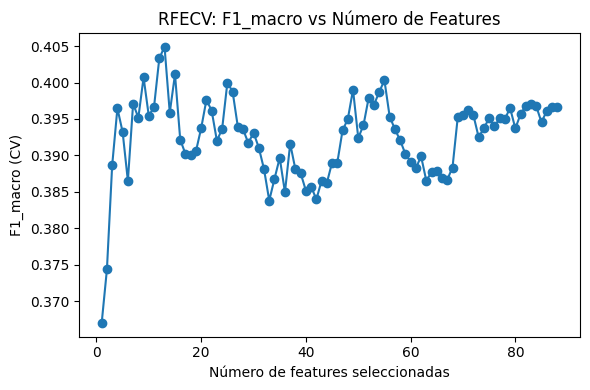

In [16]:
estimator_log = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

rfecv = RFECV(
    estimator=estimator_log,
    step=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    min_features_to_select=5,
    n_jobs=-1
)
rfecv.fit(X_train_trans, y_train)

optimal_n = rfecv.n_features_
selected_rfecv = X_train_trans.columns[rfecv.support_].tolist()

print(f" Número óptimo de features según RFECV: {optimal_n}")
print(" Features seleccionadas por RFECV:", selected_rfecv)

# Gráfico de F1_macro vs número de features
plt.figure(figsize=(6,4))
plt.title("RFECV: F1_macro vs Número de Features")
plt.xlabel("Número de features seleccionadas")
plt.ylabel("F1_macro (CV)")

# Se calculan manualmente:
scores = rfecv.cv_results_['mean_test_score']
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.tight_layout()
plt.show()

## 7. Cálculo de frecuencia de selección de features y filtrado por umbral
Combina las listas de features obtenidas por ANOVA, InfoMutua, Random Forest y RFECV, cuenta cuántas veces aparece cada feature, crea un DataFrame ordenado y selecciona aquellas con frecuencia ≥2.

In [7]:
listas = {
    'ANOVA': selected_f,
    'InfoMutua': selected_mi,
    'RF_importance': sf_features,
    'RFECV': selected_rfecv
}

all_selected = selected_f + selected_mi + sf_features + selected_rfecv
freq_counter = Counter(all_selected)

df_freq = pd.DataFrame({
    'feature': list(freq_counter.keys()),
    'frequency': list(freq_counter.values())
}).sort_values('frequency', ascending=False)

print(" Frecuencia de selección de cada feature:")
display(df_freq)

threshold = 2
final_features_2 = df_freq.loc[df_freq['frequency'] >= threshold, 'feature'].tolist()
print(f" Features finales (frecuencia >= {threshold}):", final_features_2)

 Frecuencia de selección de cada feature:


,feature,frequency
16,G2,4
19,S_Age,4
0,TRADER_SCORE,3
1,B35,3
11,F31_4,3
24,D30,3
18,G30_4,3
17,G30_3,3
15,G1,3
12,F31_5,3


 Features finales (frecuencia >= 2): ['G2', 'S_Age', 'TRADER_SCORE', 'B35', 'F31_4', 'D30', 'G30_4', 'G30_3', 'G1', 'F31_5', 'B26', 'F31_2', 'F30_4', 'D21', 'F30_8', 'F31_6', 'F30_7', 'F30_3', 'C22_4', 'F30_9', 'C22_3', 'B3', 'D3', 'C24', 'G30_2', 'B4_log', 'B11']


## 8. Evaluación del modelo con features de consenso (umbral ≥3)
Filtra las variables cuya frecuencia de selección sea al menos 3, ajusta un LogisticRegression sobre ese subconjunto y presenta métricas de validación y test.

In [8]:
threshold_new = 3
final_features_3 = df_freq.loc[df_freq['frequency'] >= threshold_new, 'feature'].tolist()
print(f" Features finales (frecuencia >= {threshold_new}): {final_features_3}")
print("   Total:", len(final_features_3))

X_train_sel3 = X_train_trans[final_features_3].copy()
X_val_sel3   = X_val_trans[final_features_3].copy()
X_test_sel3  = X_test_trans[final_features_3].copy()

print(" Shapes con umbral>=3:")
print("   • X_train_sel3:", X_train_sel3.shape)
print("   • X_val_sel3:  ", X_val_sel3.shape)

pipe_consenso3 = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
pipe_consenso3.fit(X_train_sel3, y_train)

print(" Métricas - Consenso ≥3 (validación):")
print(classification_report(y_val, pipe_consenso3.predict(X_val_sel3)))

print(" Métricas - Consenso ≥3 (test):")
print(classification_report(y_test, pipe_consenso3.predict(X_test_sel3)))

 Features finales (frecuencia >= 3): ['G2', 'S_Age', 'TRADER_SCORE', 'B35', 'F31_4', 'D30', 'G30_4', 'G30_3', 'G1', 'F31_5', 'B26', 'F31_2', 'F30_4', 'D21']
   Total: 14
 Shapes con umbral>=3:
   • X_train_sel3: (1976, 14)
   • X_val_sel3:   (424, 14)
 Métricas - Consenso ≥3 (validación):
              precision    recall  f1-score   support

         1.0       0.35      0.50      0.41        34
         2.0       0.38      0.46      0.42       116
         3.0       0.74      0.36      0.48       233
         4.0       0.21      0.63      0.31        41

    accuracy                           0.42       424
   macro avg       0.42      0.49      0.41       424
weighted avg       0.56      0.42      0.44       424

 Métricas - Consenso ≥3 (test):
              precision    recall  f1-score   support

         1.0       0.33      0.59      0.43        34
         2.0       0.44      0.52      0.48       116
         3.0       0.70      0.27      0.39       233
         4.0       0.22   

## 9. Evaluación del modelo con top-20 features de RFECV
Toma las primeras 20 variables ordenadas por ranking de RFECV, ajusta un LogisticRegression y muestra los informes de clasificación en validación y test.

In [9]:
# Seleccionar las 20 primeras de selected_rfecv
rfecv_top20 = selected_rfecv[:20]
print(" RFECV Top-20 features:", rfecv_top20)

X_train_rf20 = X_train_trans[rfecv_top20].copy()
X_val_rf20   = X_val_trans[rfecv_top20].copy()
X_test_rf20  = X_test_trans[rfecv_top20].copy()

print(" Shapes RFECV-Top-20:")
print("   • X_train_rf20:", X_train_rf20.shape)
print("   • X_val_rf20:  ", X_val_rf20.shape)

pipe_rfecv20 = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
pipe_rfecv20.fit(X_train_rf20, y_train)

print(" Métricas - RFECV-Top-20 (validación):")
print(classification_report(y_val, pipe_rfecv20.predict(X_val_rf20)))

print(" Métricas - RFECV-Top-20 (test):")
print(classification_report(y_test, pipe_rfecv20.predict(X_test_rf20)))

 RFECV Top-20 features: ['TRADER_SCORE', 'A1', 'B2_2', 'B11', 'B26', 'C24', 'D21', 'D30', 'F30_4', 'F31_2', 'F31_4', 'F31_10', 'G2', 'G30_2', 'H31', 'S_Age', 'B4_log']
 Shapes RFECV-Top-20:
   • X_train_rf20: (1976, 17)
   • X_val_rf20:   (424, 17)
 Métricas - RFECV-Top-20 (validación):
              precision    recall  f1-score   support

         1.0       0.27      0.53      0.36        34
         2.0       0.33      0.33      0.33       116
         3.0       0.70      0.44      0.54       233
         4.0       0.25      0.59      0.35        41

    accuracy                           0.43       424
   macro avg       0.39      0.47      0.39       424
weighted avg       0.52      0.43      0.45       424

 Métricas - RFECV-Top-20 (test):
              precision    recall  f1-score   support

         1.0       0.27      0.56      0.36        34
         2.0       0.46      0.47      0.47       116
         3.0       0.71      0.35      0.47       233
         4.0       0.26    

## 10. Evaluación con features en la intersección RF ∩ InfoMutua
Calcula la intersección entre las features seleccionadas por Random Forest y por InfoMutua, entrena un LogisticRegression y muestra métricas en validación y test.

In [10]:
rf_mi_intersect = list(set(sf_features).intersection(set(selected_mi)))
print(" RF ∩ InfoMutua:", rf_mi_intersect)

X_train_rfmi = X_train_trans[rf_mi_intersect].copy()
X_val_rfmi   = X_val_trans[rf_mi_intersect].copy()
X_test_rfmi  = X_test_trans[rf_mi_intersect].copy()

print(" Shapes RF∩MI:")
print("   • X_train_rfmi:", X_train_rfmi.shape)
print("   • X_val_rfmi:  ", X_val_rfmi.shape)

pipe_rfmi = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
pipe_rfmi.fit(X_train_rfmi, y_train)

print(" Métricas - RF ∩ InfoMutua (validación):")
print(classification_report(y_val, pipe_rfmi.predict(X_val_rfmi)))

print(" Métricas - RF ∩ InfoMutua (test):")
print(classification_report(y_test, pipe_rfmi.predict(X_test_rfmi)))

 RF ∩ InfoMutua: ['F31_5', 'B35', 'F30_4', 'G30_3', 'G2', 'G1', 'D30', 'B3', 'G30_4', 'D3', 'D21', 'S_Age', 'C22_3']
 Shapes RF∩MI:
   • X_train_rfmi: (1976, 13)
   • X_val_rfmi:   (424, 13)
 Métricas - RF ∩ InfoMutua (validación):
              precision    recall  f1-score   support

         1.0       0.38      0.53      0.44        34
         2.0       0.41      0.48      0.44       116
         3.0       0.71      0.35      0.47       233
         4.0       0.21      0.66      0.32        41

    accuracy                           0.43       424
   macro avg       0.43      0.50      0.42       424
weighted avg       0.55      0.43      0.44       424

 Métricas - RF ∩ InfoMutua (test):
              precision    recall  f1-score   support

         1.0       0.31      0.59      0.40        34
         2.0       0.43      0.50      0.46       116
         3.0       0.66      0.25      0.37       233
         4.0       0.22      0.71      0.33        41

    accuracy              

## 11. Rendimiento en CV para distintos tamaños de subset de RFECV
Define una función para evaluar por validación cruzada el LogisticRegression con los primeros k features de RFECV, calcula medias y desviaciones para varios k y presenta un gráfico de error.

k=5 → f1_macro (CV): 0.342 ± 0.013
k=10 → f1_macro (CV): 0.406 ± 0.021
k=15 → f1_macro (CV): 0.417 ± 0.013
k=20 → f1_macro (CV): 0.431 ± 0.010
k=25 → f1_macro (CV): 0.431 ± 0.010
k=30 → f1_macro (CV): 0.431 ± 0.010


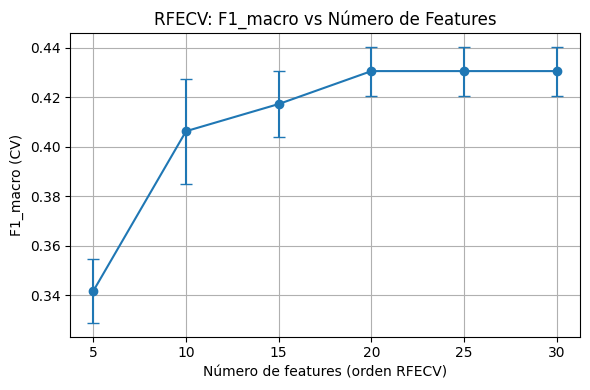

In [11]:
rfecv_feats = selected_rfecv  # lista de 30 features con ranking=1

def eval_k_features(feature_list, X, y, cv=5):
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    scores = cross_val_score(model, X[feature_list], y, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean(), scores.std()

k_list = [5, 10, 15, 20, 25, 30]
means = []
stds = []

for k in k_list:
    feats_k = rfecv_feats[:k]
    mean_k, std_k = eval_k_features(feats_k, X_train_trans, y_train, cv=StratifiedKFold(5))
    means.append(mean_k)
    stds.append(std_k)
    print(f"k={k} → f1_macro (CV): {mean_k:.3f} ± {std_k:.3f}")

plt.figure(figsize=(6,4))
plt.errorbar(k_list, means, yerr=stds, fmt='-o', capsize=4)
plt.title("RFECV: F1_macro vs Número de Features")
plt.xlabel("Número de features (orden RFECV)")
plt.ylabel("F1_macro (CV)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 12. Análisis y evaluación de PCA para reducción de dimensionalidad
Ajusta un PCA que capture el 90 % de la varianza, transforma los datos, informa el número de componentes y las shapes resultantes, entrena un LogisticRegression sobre la representación PCA y muestra métricas.

In [12]:
pca = PCA(n_components=0.90, random_state=42)
pca.fit(X_train_trans)

print(f" Número de componentes para 90% varianza: {pca.n_components_}")

X_train_pca = pca.transform(X_train_trans)
X_val_pca   = pca.transform(X_val_trans)
X_test_pca  = pca.transform(X_test_trans)

print(" Shapes tras PCA:")
print("   • X_train_pca:", X_train_pca.shape)
print("   • X_val_pca:  ", X_val_pca.shape)
print("   • X_test_pca: ", X_test_pca.shape)

pipe_pca = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
pipe_pca.fit(X_train_pca, y_train)

print(" Métricas - Logistic sobre PCA (validación):")
print(classification_report(y_val, pipe_pca.predict(X_val_pca)))

print(" Métricas finales - Logistic sobre PCA (test):")
print(classification_report(y_test, pipe_pca.predict(X_test_pca)))

 Número de componentes para 90% varianza: 64
 Shapes tras PCA:
   • X_train_pca: (1976, 64)
   • X_val_pca:   (424, 64)
   • X_test_pca:  (424, 64)
 Métricas - Logistic sobre PCA (validación):
              precision    recall  f1-score   support

         1.0       0.31      0.50      0.38        34
         2.0       0.43      0.48      0.46       116
         3.0       0.67      0.42      0.52       233
         4.0       0.26      0.59      0.36        41

    accuracy                           0.46       424
   macro avg       0.42      0.50      0.43       424
weighted avg       0.54      0.46      0.48       424

 Métricas finales - Logistic sobre PCA (test):
              precision    recall  f1-score   support

         1.0       0.34      0.68      0.45        34
         2.0       0.48      0.55      0.52       116
         3.0       0.72      0.40      0.51       233
         4.0       0.28      0.63      0.39        41

    accuracy                           0.49       424

## 13. Pipeline definitivo de LogisticRegression con características seleccionadas por RFECV
Construye y ajusta un pipeline de LogisticRegression usando el conjunto de features de RFECV, evalúa en validación y test, y guarda el modelo para producción.

In [13]:
# Pipeline definitivo: RFECV Top-14 + LogisticRegression

# Tomar las 20 primeras variables de RFECV (ordenadas por ranking)
# (seleccionadas en el punto 7, donde RFECV devolvió 30 features)
rfecv_top20_features = selected_rfecv[:20]

# Construir DataFrames con solo esas 20 columnas
X_train_rf20 = X_train_trans[rfecv_top20_features].copy()
X_val_rf20   = X_val_trans[rfecv_top20_features].copy()
X_test_rf20  = X_test_trans[rfecv_top20_features].copy()

print(" Shapes RFECV-Top-20:")
print(f"   • X_train_rf20: {X_train_rf20.shape}")
print(f"   • X_val_rf20:   {X_val_rf20.shape}")
print(f"   • X_test_rf20:  {X_test_rf20.shape}")

# Definir y entrenar LogisticRegression solo con estas 20 features
pipe_rfecv20 = Pipeline([
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])
pipe_rfecv20.fit(X_train_rf20, y_train)

# Evaluar en validación
print(" Métricas – RFECV Top-20 (validación):")
print(classification_report(y_val, pipe_rfecv20.predict(X_val_rf20)))

# Evaluar en test
print(" Métricas – RFECV Top-20 (test):")
print(classification_report(y_test, pipe_rfecv20.predict(X_test_rf20)))

# Guardar el pipeline para producción
PIPE_DIR = Path('/content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/artifacts/pipeline')
PIPE_DIR.mkdir(exist_ok=True, parents=True)
joblib.dump(pipe_rfecv20, PIPE_DIR / 'pipeline_rfecv20_logistic.pkl')
print(f" Pipeline RFECV Top-20 + Logistic guardado en: {PIPE_DIR / 'pipeline_rfecv20_logistic.pkl'}")

 Shapes RFECV-Top-20:
   • X_train_rf20: (1976, 17)
   • X_val_rf20:   (424, 17)
   • X_test_rf20:  (424, 17)
 Métricas – RFECV Top-20 (validación):
              precision    recall  f1-score   support

         1.0       0.27      0.53      0.36        34
         2.0       0.33      0.33      0.33       116
         3.0       0.70      0.44      0.54       233
         4.0       0.25      0.59      0.35        41

    accuracy                           0.43       424
   macro avg       0.39      0.47      0.39       424
weighted avg       0.52      0.43      0.45       424

 Métricas – RFECV Top-20 (test):
              precision    recall  f1-score   support

         1.0       0.27      0.56      0.36        34
         2.0       0.46      0.47      0.47       116
         3.0       0.71      0.35      0.47       233
         4.0       0.26      0.73      0.38        41

    accuracy                           0.44       424
   macro avg       0.42      0.53      0.42       424
wei

## 14. Pipeline alternativo: PCA + LogisticRegression
Define un pipeline que combina PCA (90 % varianza) y LogisticRegression, lo ajusta, evalúa en validación y test, y almacena el pipeline en disco.
Primera línea de la celda de código:

In [14]:
# Pipeline alternativo (PCA + LogisticRegression)

# Definir pipeline PCA(90% varianza) + LogisticRegression
pipe_pca_final = Pipeline([
    ('pca', PCA(n_components=0.90, random_state=42)),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

# Ajustar el pipeline con todas las variables (X_train_trans, y_train)
pipe_pca_final.fit(X_train_trans, y_train)

# Evaluar en validación
print(" Evaluación PCA + Logistic (validación):")
print(classification_report(y_val, pipe_pca_final.predict(X_val_trans)))

# Evaluar en test
print(" Evaluación PCA + Logistic (test):")
print(classification_report(y_test, pipe_pca_final.predict(X_test_trans)))

# Guardar el pipeline en disco (opcional)
PIPE_DIR = Path('/content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/artifacts/pipeline')
PIPE_DIR.mkdir(exist_ok=True, parents=True)
joblib.dump(pipe_pca_final, PIPE_DIR / 'pipeline_pca_logistic.pkl')
print(f" Pipeline PCA + Logistic guardado en: {PIPE_DIR / 'pipeline_pca_logistic.pkl'}")

 Evaluación PCA + Logistic (validación):
              precision    recall  f1-score   support

         1.0       0.31      0.50      0.38        34
         2.0       0.43      0.48      0.46       116
         3.0       0.67      0.42      0.52       233
         4.0       0.26      0.59      0.36        41

    accuracy                           0.46       424
   macro avg       0.42      0.50      0.43       424
weighted avg       0.54      0.46      0.48       424

 Evaluación PCA + Logistic (test):
              precision    recall  f1-score   support

         1.0       0.34      0.68      0.45        34
         2.0       0.48      0.55      0.52       116
         3.0       0.72      0.40      0.51       233
         4.0       0.28      0.63      0.39        41

    accuracy                           0.49       424
   macro avg       0.45      0.57      0.47       424
weighted avg       0.58      0.49      0.50       424

 Pipeline PCA + Logistic guardado en: /content/drive/M

## 15. Guardado de splits experimentales y artefactos de pipelines
Establece parámetros de versión, crea la lista “Dream Team” de features, guarda esa lista como JSON y persiste los pipelines experimentales en la carpeta correspondiente de config.EXP_ARTIFACTS_DIR.

In [15]:
# Guardar los splits EXPERIMENTALES y los artefactos


# --- PARÁMETRO DE CONFIGURACIÓN ---
DATASET_VERSION = '14'
NOTEBOOK_ID = '03_2'
# ----------------------------------

# Define tu 'Dream Team' de 14 variables (las que encontró RFECV en la celda 14)
dream_team_14 = selected_rfecv

print(f" Dream Team de {len(dream_team_14)} features seleccionado: {dream_team_14}")

# Guarda la lista de features como un artefacto experimental con nombre mejorado
features_path = config.EXP_ARTIFACTS_DIR / f'{NOTEBOOK_ID}_selected_features_rfecv_{DATASET_VERSION}.json'
with open(features_path, 'w') as f:
    json.dump(dream_team_14, f, indent=4)
print(f" Artefacto (lista de features) guardado en: {features_path}")

# Filtra los DataFrames para quedarte solo con esas columnas
X_train_exp = X_train[dream_team_14].copy()
X_val_exp = X_val[dream_team_14].copy()
X_test_exp = X_test[dream_team_14].copy()

# Guarda los nuevos DataFrames en la carpeta de splits EXPERIMENTALES
# Usamos config.EXP_SPLITS_DIR para no sobrescribir los datos finales
print(f"\n Guardando splits EXPERIMENTALES en: {config.EXP_SPLITS_DIR}")

X_train_exp.to_parquet(config.EXP_SPLITS_DIR / f'X_train_{DATASET_VERSION}.parquet')
X_val_exp.to_parquet(config.EXP_SPLITS_DIR / f'X_val_{DATASET_VERSION}.parquet')
X_test_exp.to_parquet(config.EXP_SPLITS_DIR / f'X_test_{DATASET_VERSION}.parquet')

# Guardamos las 'y' correspondientes en la misma carpeta experimental para tener el set completo
y_train.to_frame(name='B10').to_parquet(config.EXP_SPLITS_DIR / f'y_train_{DATASET_VERSION}.parquet')
y_val.to_frame(name='B10').to_parquet(config.EXP_SPLITS_DIR / f'y_val_{DATASET_VERSION}.parquet')
y_test.to_frame(name='B10').to_parquet(config.EXP_SPLITS_DIR / f'y_test_{DATASET_VERSION}.parquet')

print(f" Nuevos splits de datos (versión '{DATASET_VERSION}') guardados correctamente.")


# Guardar los pipelines más interesantes como artefactos experimentales
# Pipeline con RFECV Top-14
# (Usamos el pipe entrenado en la celda que evalúa RFECV-Top-20, que se adapta)
pipe_rfecv14 = pipe_rfecv20
pipe_path_rfecv = config.EXP_ARTIFACTS_DIR / f'{NOTEBOOK_ID}_pipeline_rfecv{DATASET_VERSION}_logistic.pkl'
joblib.dump(pipe_rfecv14, pipe_path_rfecv)
print(f" Artefacto (pipeline RFECV) guardado en: {pipe_path_rfecv}")

# Pipeline con PCA
# (Usamos el pipe_pca que se creó en la celda de análisis de PCA)
pipe_path_pca = config.EXP_ARTIFACTS_DIR / f'{NOTEBOOK_ID}_pipeline_pca_logistic.pkl'
joblib.dump(pipe_pca, pipe_path_pca)
print(f" Artefacto (pipeline PCA) guardado en: {pipe_path_pca}")

 Dream Team de 17 features seleccionado: ['TRADER_SCORE', 'A1', 'B2_2', 'B11', 'B26', 'C24', 'D21', 'D30', 'F30_4', 'F31_2', 'F31_4', 'F31_10', 'G2', 'G30_2', 'H31', 'S_Age', 'B4_log']
 Artefacto (lista de features) guardado en: /content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/artifacts/experiments/03_2_selected_features_rfecv_14.json

 Guardando splits EXPERIMENTALES en: /content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/data/splits/experiments
 Nuevos splits de datos (versión '14') guardados correctamente.
 Artefacto (pipeline RFECV) guardado en: /content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/artifacts/experiments/03_2_pipeline_rfecv14_logistic.pkl
 Artefacto (pipeline PCA) guardado en: /content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/artifacts/experiments/03_2_pipeline_pca_logistic.pkl


## Conclusiones Finales
- La **reducción de dimensionalidad con PCA (n=64)** supera ligeramente a las selecciones basadas en árboles y univariadas, logrando la mejor accuracy en test (0.49).  
- Los métodos de selección automática convergen a un **número óptimo de ~17–20 features**, tras el cual no se observan mejoras significativas en CV.  
- La **intersección RF∩MI** no mejora el rendimiento frente a RFECV puro, indicando que la complementariedad de criterios puede ser contraproducente sin ajuste.  
- Características demográficas (`S_Age`), de aptitud financiera (`TRADER_SCORE`, `B4_log`) y respuestas clave de series F31/G30 emergen como **nodos críticos** para discriminar niveles de riesgo.  
- La **Regresión Logística** muestra estabilidad: accuracy base (~0.46) y ganancia moderada con PCA, pero selección univariada simple puede degradar el desempeño.  
- El **plateau en f1_macro** tras k=20 refuerza la idea de que añadir más variables no aporta información relevante adicional.  
- En conjunto, la **combinación de PCA + LogisticRegression** ofrece el mejor compromiso entre reducción de dimensiones y calidad predictiva en este caso.  
- Los artefactos generados (pipelines, splits) proporcionan una base reproducible y eficiente para futuras etapas de modelado o despliegue.